In [1]:
import torch
from torch import nn 
from torchvision import transforms 
import os 
import numpy as np 
from skimage.io import imread 
from torchvision.models import vgg19
from torch.utils.data import DataLoader, TensorDataset
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt 
import random 


device = ("mps"
         if torch.backends.mps.is_available()
         else "cuda"
         if torch.cuda.is_available()
         else "cpu")
device

'cuda'

In [2]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act=True, use_bn=True, discriminator=False, **kwargs):
        super().__init__()
        self.use_act = use_act
        self.convblock = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = nn.ReLU(0.2) if discriminator else nn.PReLU(num_parameters=out_channels)

    def forward(self, x):
        out = self.act(self.bn(self.convblock(x))) if self.use_act else self.bn(self.convblock(x))
        return out


class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, kernel_size=3, stride=1, padding=1)
        self.px = nn.PixelShuffle(upscale_factor=scale_factor) # Change to float
        self.act = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.act(self.px(self.conv(x)))



class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1, use_act=True)
        self.conv2 = ConvBlock(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1, use_act=False)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels=in_channels, out_channels=num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(in_channels=num_channels) for _ in range(num_blocks)])
        self.conv = ConvBlock(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpSampleBlock(in_channels=num_channels, scale_factor=2), 
                                      UpSampleBlock(in_channels=num_channels, scale_factor=2))
        self.final = ConvBlock(in_channels=num_channels, out_channels=in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.conv(x) + x
        x = self.upsamples(x)
        return self.final(x)  # Change to float


In [3]:

gen = Generator().to(device)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, 
                 features = [64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
            ConvBlock(in_channels = in_channels, 
                     out_channels = feature,
                     kernel_size = 3, 
                     stride = 1 + idx%2,
                     padding = 1, 
                     use_act=True,
                     use_bn = False if idx ==0 else True))
            in_channels = feature
        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)), 
            nn.Flatten(), 
            nn.Linear(512*6*6, 1024), 
            nn.LeakyReLU(0.2), 
            nn.Linear(1024, 1))
        
    def forward(self, x):
        x = self.blocks(x)
        x = self.classifier(x)
        return x
        

In [5]:
discrim = Discriminator().to(device)


In [6]:
from torchvision.models import vgg19 
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss()
        self.vgg = vgg19().features[:10].eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False 
            
            
    def forward(self, inputs, targets):
        vgg_input_features = self.vgg(inputs)
        vgg_target_features = self.vgg(targets)
        return self.loss(vgg_input_features, vgg_target_features)

In [7]:
import os
from skimage.io import imread
from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image

high_res_train_base_path = "/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_HR/"
low_res_4x_train_base_path = "/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_LR_bicubic_X4/X4/"
high_res_train_image_files = sorted(os.listdir(high_res_train_base_path))[:100]
low_res_4x_train_image_files = sorted(os.listdir(low_res_4x_train_base_path))[:100]

high_res_size = 512
low_res_size = 128

highres_transform = transforms.Compose(
    [   transforms.Resize((high_res_size, high_res_size), interpolation = Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5 ])
    ]
)

lowres_transform = transforms.Compose(
    [
        transforms.Resize((low_res_size, low_res_size), interpolation=Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
        
    ]
)


def preprocess(image_filename, base_path, high_res = True):
    image_file_path = os.path.join(base_path, image_filename)
    im = Image.open(image_file_path)
    
    # Resize the image to a common shape, for example, (256, 256)
    if high_res:

        im = highres_transform(im)
    else:
        im = lowres_transform(im)
    return im

# Create separate lists for high-res and low-res images
high_res_images = [preprocess(image_file, high_res_train_base_path) 
                   for image_file in tqdm(high_res_train_image_files, total=len(high_res_train_image_files))]
low_res_4x_images = [preprocess(image_file, low_res_4x_train_base_path, high_res = False) 
                     for image_file in tqdm(low_res_4x_train_image_files, total=len(low_res_4x_train_image_files))]

# Using TensorDataset with separate tensors
train_dataset = TensorDataset(torch.stack(high_res_images), torch.stack(low_res_4x_images))

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 - discriminator loss: 94.54
Epoch 1 - generator loss:  0.03



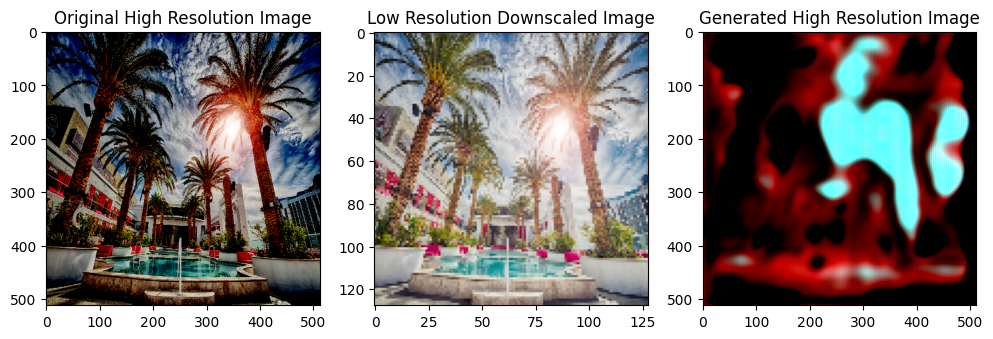

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 - discriminator loss: 25.71
Epoch 2 - generator loss:  0.01



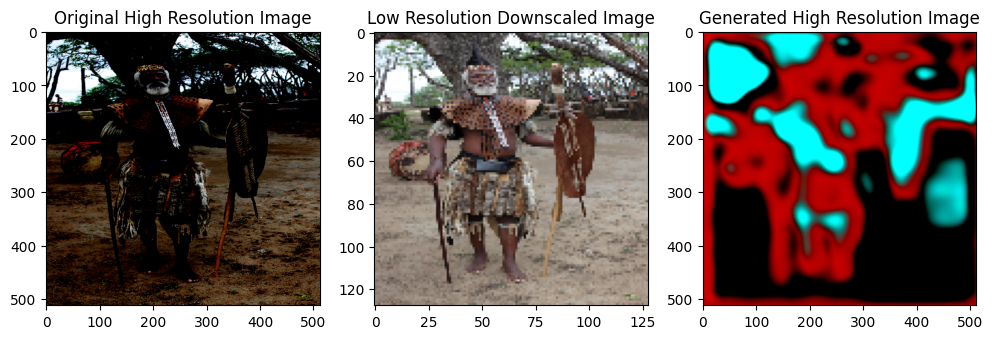

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 - discriminator loss: 13.77
Epoch 3 - generator loss:  0.01



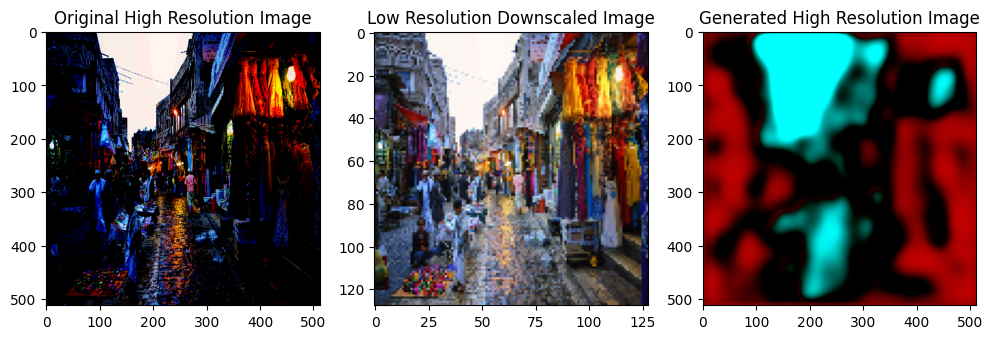

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 - discriminator loss: 7.52
Epoch 4 - generator loss:  0.02



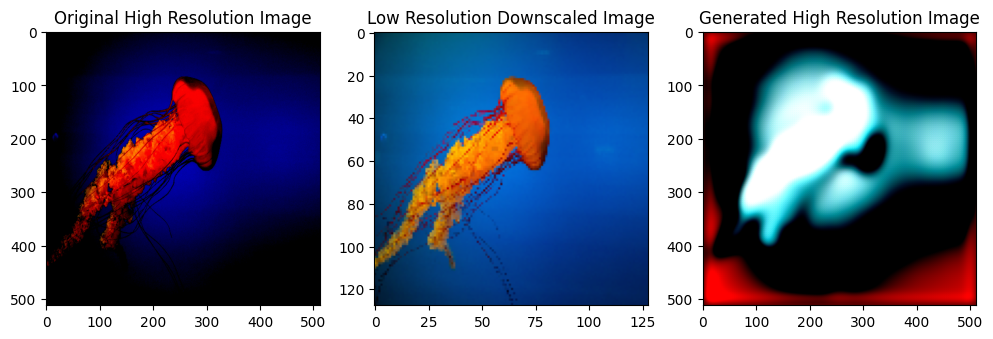

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 - discriminator loss: 6.29
Epoch 5 - generator loss:  0.02



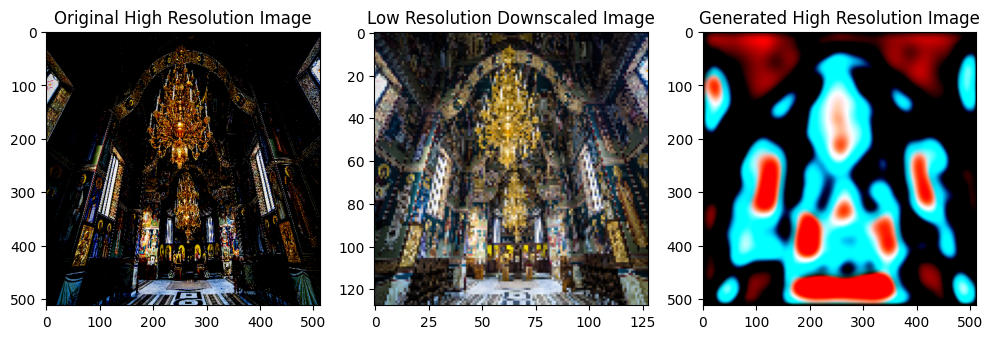

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 - discriminator loss: 6.17
Epoch 6 - generator loss:  0.01



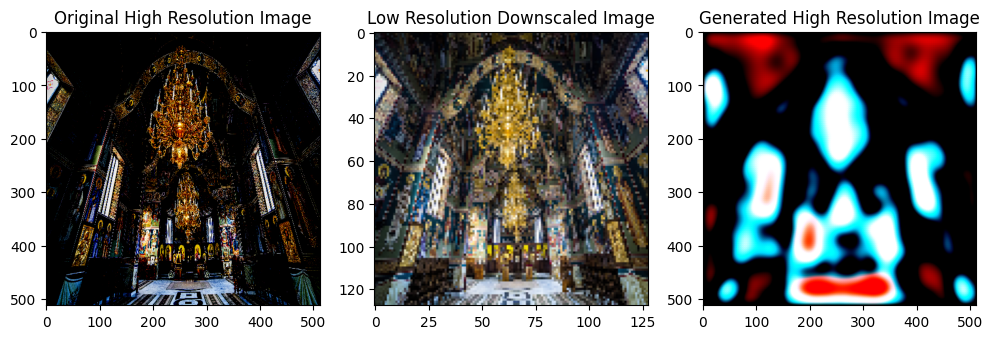

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 - discriminator loss: 3.54
Epoch 7 - generator loss:  0.02



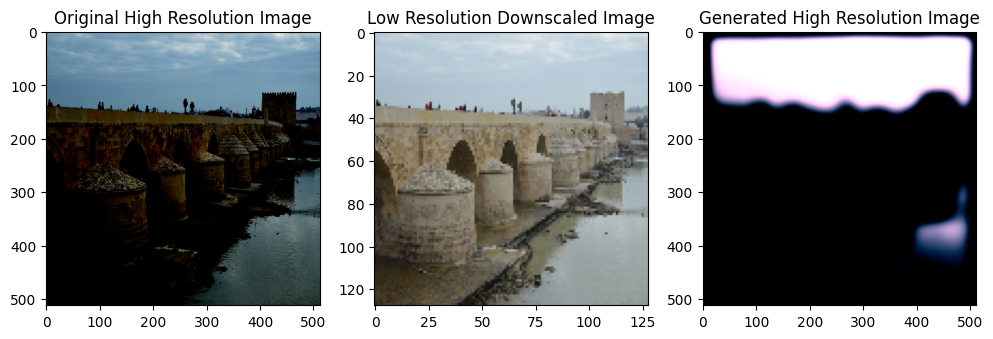

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 - discriminator loss: 2.24
Epoch 8 - generator loss:  0.02



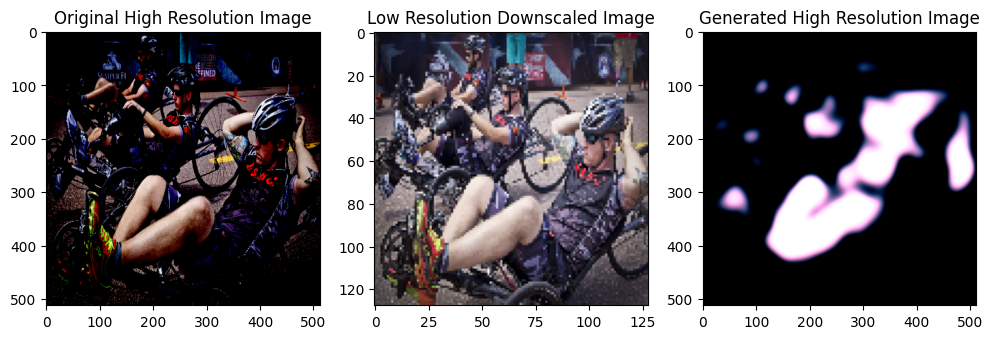

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 - discriminator loss: 4.99
Epoch 9 - generator loss:  0.01



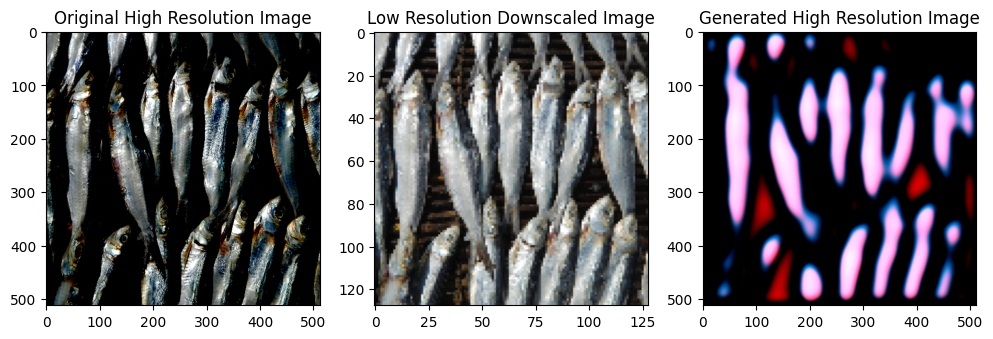

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 - discriminator loss: 4.57
Epoch 10 - generator loss:  0.01



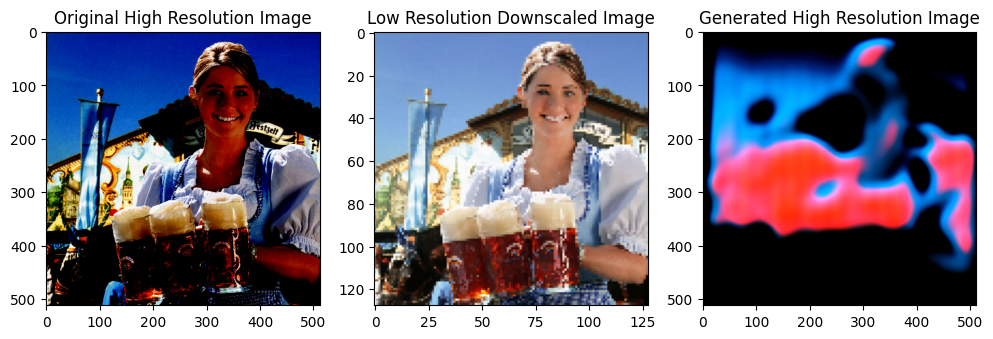

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 - discriminator loss: 8.05
Epoch 11 - generator loss:  0.01



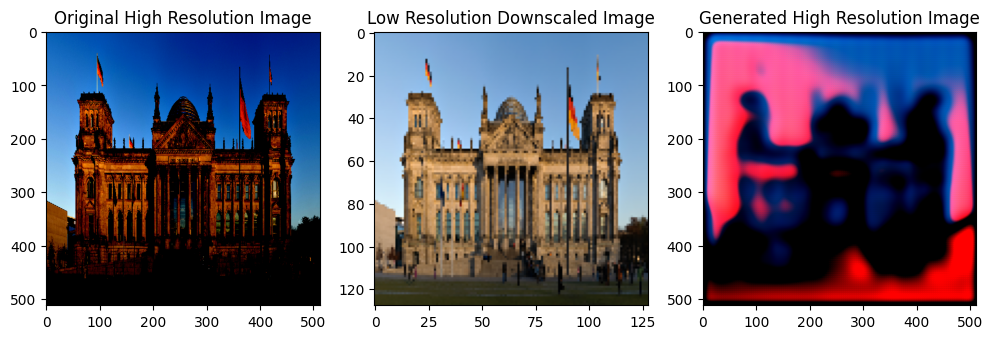

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 - discriminator loss: 5.84
Epoch 12 - generator loss:  0.01



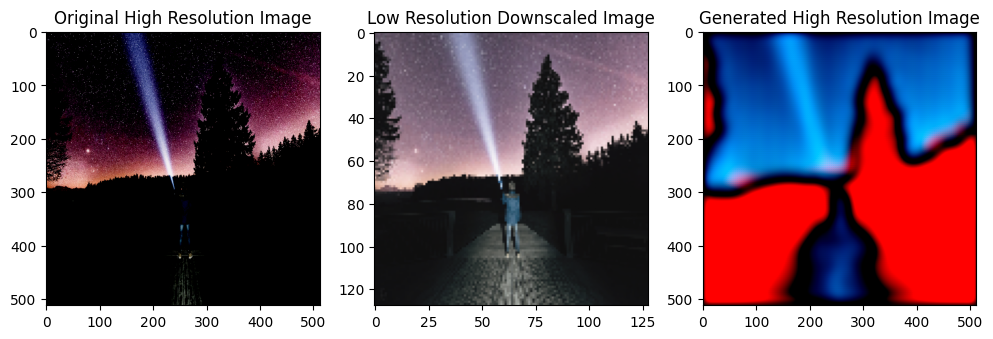

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 - discriminator loss: 5.05
Epoch 13 - generator loss:  0.01



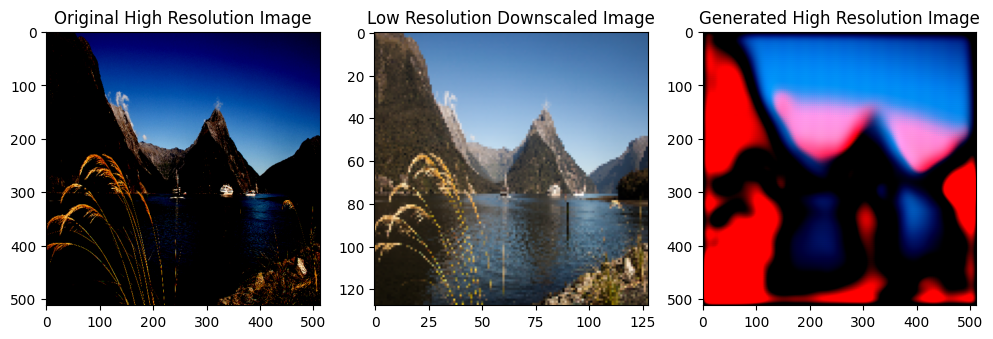

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 - discriminator loss: 4.23
Epoch 14 - generator loss:  0.01



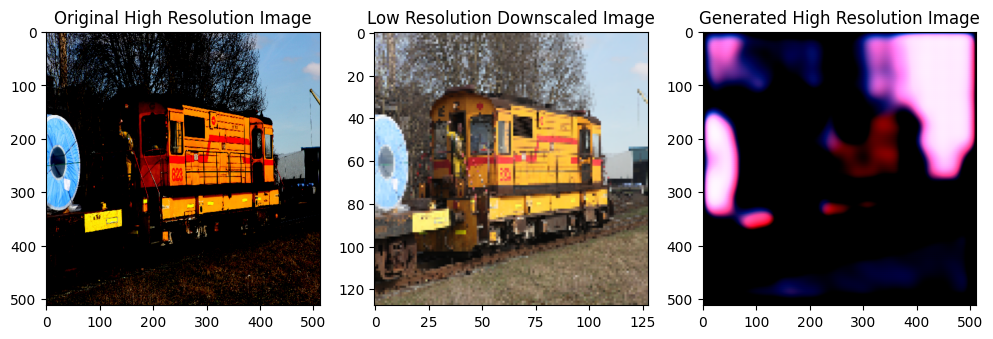

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 - discriminator loss: 4.57
Epoch 15 - generator loss:  0.01



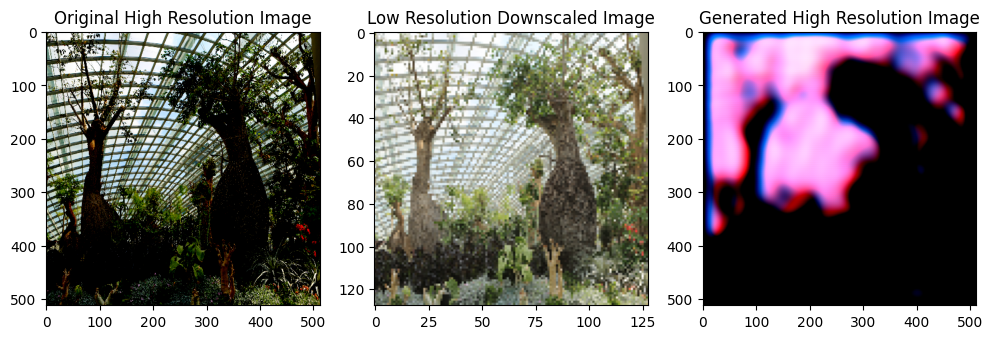

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 - discriminator loss: 4.26
Epoch 16 - generator loss:  0.01



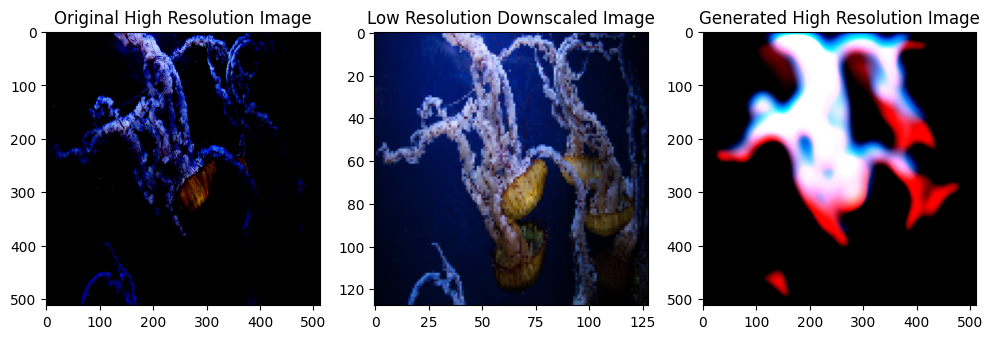

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 - discriminator loss: 5.07
Epoch 17 - generator loss:  0.01



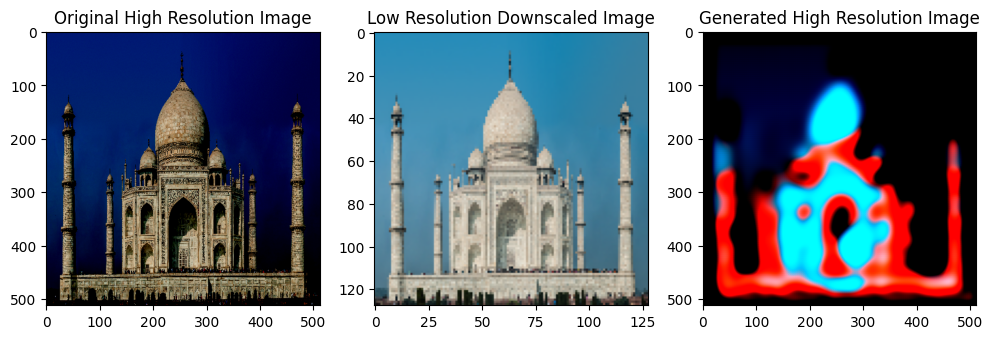

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 - discriminator loss: 2.79
Epoch 18 - generator loss:  0.00



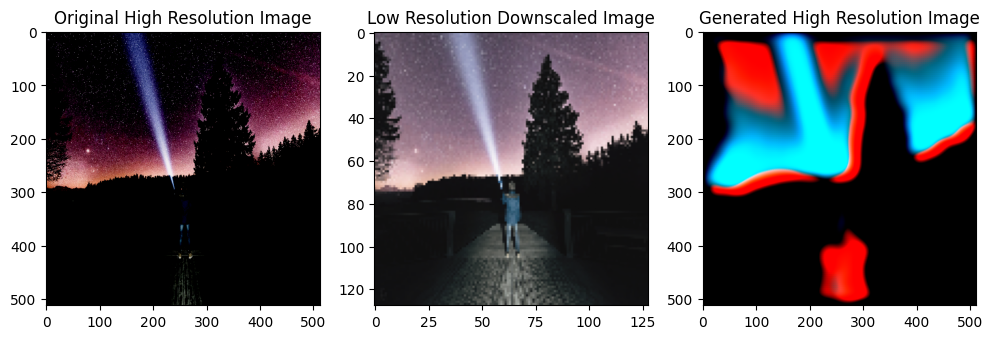

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
opt_gen = torch.optim.Adam(gen.parameters(), lr = 1e-2, betas = (0.9, 0.999))
opt_discrim = torch.optim.Adam(discrim.parameters(), lr = 1e-2, betas = (0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss().to(device)

NUM_EPOCHS = 50
losses_discrim = []
losses_gen = []
print_loss_every = 8
gradient_accumulation_steps_discrim = 1
gradient_accumulation_steps_gen = 1



for epoch  in tqdm(range(NUM_EPOCHS), total = NUM_EPOCHS):
    for idx, (high_res, low_res) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        
        #Training the discriminator
        fake = gen(low_res)
        discrim_real = discrim(high_res)
        discrim_fake = discrim(fake.detach())
        discrim_loss_real = bce(
            discrim_real, torch.ones_like(discrim_real) 
            - 0.1 * torch.rand_like(discrim_real))
        discrim_loss_fake = bce(discrim_fake, torch.zeros_like(discrim_fake))
        loss_discrim = discrim_loss_fake + discrim_loss_real 
        losses_discrim.append(loss_discrim.item())
        
        
        loss_discrim.backward()
        if (idx + 1) % gradient_accumulation_steps_discrim == 0:
            opt_discrim.step()
            opt_discrim.zero_grad()
        
        discrim_fake = discrim(fake)
        adversarial_loss = 1e-3 * bce(discrim_fake, torch.ones_like(discrim_fake))
        loss_for_vgg =  0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss 
        losses_gen.append(gen_loss.item())
        
        gen_loss.backward()
        if (idx + 1) % gradient_accumulation_steps_gen == 0:
            opt_gen.step()
            opt_gen.zero_grad()
        
    
    print("Epoch {} - discriminator loss: {:.2f}".format(epoch + 1, 
                                                              sum(losses_discrim[-len(train_dataloader):])/len(train_dataloader)))
    print("Epoch {} - generator loss:  {:.2f}\n".format(epoch + 1, 
                                                            sum(losses_gen[-len(train_dataloader):])/len(train_dataloader)))
    random_img_file_no = random.randint(0, 99)
    high_res_img_file = high_res_train_image_files[random_img_file_no]
    low_res_img_file = low_res_4x_train_image_files[random_img_file_no]
    high_res_img = preprocess(base_path = high_res_train_base_path, 
                         image_filename = high_res_img_file, 
                         high_res = True)
    low_res_img = preprocess(base_path = low_res_4x_train_base_path, 
                        image_filename = low_res_img_file, 
                        high_res = False)
    high_res_generated = gen(low_res_img.unsqueeze(0).to(device)).squeeze()
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 12))
    ax[0].imshow(high_res_img.permute(1, 2, 0).numpy())
    ax[0].set_title("Original High Resolution Image")
    ax[1].imshow(low_res_img.permute(1, 2, 0).numpy())
    ax[1].set_title("Low Resolution Downscaled Image")
    ax[2].imshow(high_res_generated.detach().permute(1, 2, 0).to("cpu").numpy())
    ax[2].set_title("Generated High Resolution Image")
    plt.show()
        


In [ ]:
import matplotlib.pyplot as plt 
plt.plot(losses_discrim)
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(losses_gen)
plt.show()

In [ ]:
import random
random_img_file_no = random.randint(0, 99)
high_res_img_file = high_res_train_image_files[random_img_file_no]
low_res_img_file = low_res_4x_train_image_files[random_img_file_no]
high_res_img = preprocess(base_path = high_res_train_base_path, 
                         image_filename = high_res_img_file, 
                         high_res = True)
low_res_img = preprocess(base_path = low_res_4x_train_base_path, 
                        image_filename = low_res_img_file, 
                        high_res = False)
high_res_generated = gen(low_res_img.unsqueeze(0).to(device)).squeeze()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 12))
ax[0].imshow(high_res_img.permute(1, 2, 0).numpy())
ax[0].set_title("Original High Resolution Image")
ax[1].imshow(low_res_img.permute(1, 2, 0).numpy())
ax[1].set_title("Low Resolution Downscaled Image")
ax[2].imshow(high_res_generated.detach().permute(1, 2, 0).to("cpu").numpy())
ax[2].set_title("Generated High Resolution Image")
plt.show()